In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
from DataFetcher.DataBase.DataBaseAggregator import *
from Strategies.PairTrading_AllCorrelations import *


C:\Users\ansaggar\AppData\Local\Programs\Python\Python38-32\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
import matplotlib
from matplotlib import figure
import matplotlib.pyplot as plt


In [54]:
DB = DataBaseAggregator()

In [5]:
st

NameError: name 'st' is not defined

In [56]:
start = datetime(2020, 9, 20)
end = datetime(2020, 10, 15)
#stocks = ['NIFTY','BAJAJ-AUTO.NS', 'BAJAJFINSV.NS', 'BAJFINANCE.NS', 'BHARTIARTL.NS', 'BRITANNIA.NS', 'CIPLA.NS',
#              'COALINDIA.NS', 'GAIL.NS', 'GRASIM.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS', 'ICICIBANK.NS', 'INDUSINDBK.NS',
#              'ITC.NS', 'KOTAKBANK.NS', 'LT.NS', 'MARUTI.NS', 'NESTLEIND.NS', 'NTPC.NS', 'ONGC.NS', 'RELIANCE.NS',
#              'SHREECEM.NS', 'TATASTEEL.NS', 'TCS.NS', 'TECHM.NS', 'TITAN.NS', 'ULTRACEMCO.NS', 'WIPRO.NS', 'ZEEL.NS',
#              'AXISBANK.NS', 'ADANIPORTS.NS', 'ASIANPAINT.NS', 'BPCL.NS', 'INFRATEL.NS', 'DRREDDY.NS', 'EICHERMOT.NS',
#              'HCLTECH.NS', 'HDFCBANK.NS', 'HDFC.NS', 'HINDUNILVR.NS', 'IOC.NS', 'INFY.NS', 'JSWSTEEL.NS', 'M&M.NS',
#              'POWERGRID.NS', 'SBIN.NS', 'SPARC.NS', 'TATAMOTORS.NS', 'UPL.NS', 'VEDL.NS', 'YESBANK.NS']#


#stocks = ['AMBUJACEM.NS','ACC.NS']#,'HDFCBANK.NS', 'HDFC.NS']

stocks = ['GBPINR=X','INR=X','JPYINR=X','EURINR=X']
strategy = PairTrading_AllCorrelations(stocks,start,end,DB )
strategy.TradingCostPErcentage = 0.005
strategy.ADFPassValue = -2
strategy.ShouldTrainWithoutCost = True
strategy.StandardDeviations = 1
strategy.SpreadDeviationRatio = 0#1/300*1/100
strategy.ShouldDownloadData = True
strategy.CacheWarmUp()
ans = strategy.runStrategy()


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GBPINR=X: 1m data not available for startTime=1600540140 and endTime=1601058540. The requested range must be within the last 30 days.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
0 of 4downloaded
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- INR=X: 1m data not available for startTime=1600540140 and endTime=1601058540. The requested range must be within the last 30 days.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1

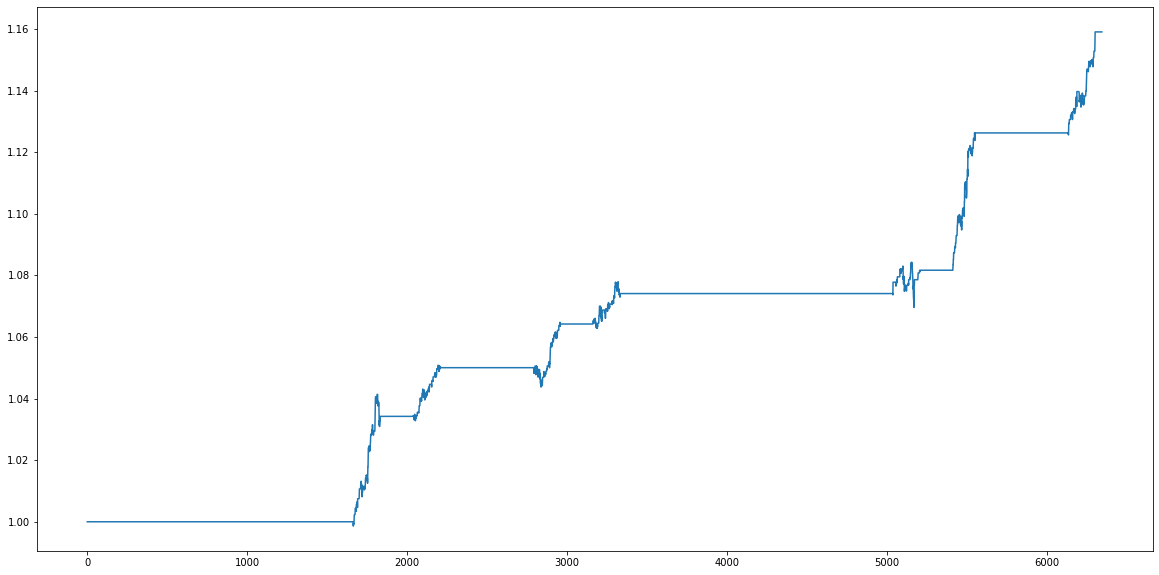

In [35]:
plt.figure(figsize=(20,10))
plt.plot( ( 1 + ans.Return).cumprod().to_list())

#plt.plot( (ans.Count).to_list())
#plt.plot(ans.Count.to_list() )

In [20]:
xs = (ans.Return+1).cumprod()
i = np.argmax(np.maximum.accumulate(xs) - xs)  # end of the period
j = np.argmax(xs[:i])  # start of period


In [51]:
def max_drawdown(returns):
    returns = (returns+1).cumprod()
    mx = returns.cummax()
    mn = returns[::-1].cummin()[::-1]
    diff = mx-mn
    index =  (mx-mn).argmax()
    return mx[index], mn[index], (mx-mn).max(), index


In [54]:
max_drawdown((ans.Return))

<ipython-input-51-9d9fd6c806a9>:5: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  index =  (mx-mn).argmax()


(0.03505594174527071,
 -0.019887006439583188,
 0.0549429481848539,
 Timestamp('2020-10-09 11:52:00'))

In [36]:
DB.OnCompleteSave()

Copying contents of input data failed, exception:[Errno 22] Invalid argument: 'C:\\Anshul\\money\\stockAndOptions\\AllData\\Backup\\2020-10-19T13-16-48C:\\Anshul\\money\\stockAndOptions\\AllData\\DataAggregator_v1_.pickle'


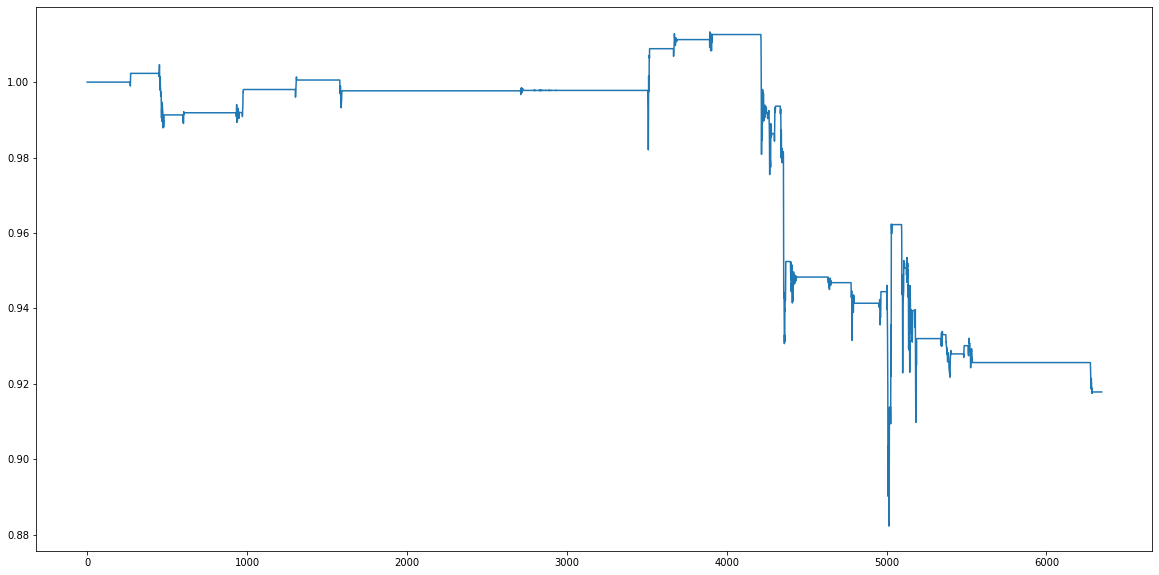

In [53]:
plt.figure(figsize=(20,10))
plt.plot((ans.Return+1).cumprod().to_list())
#plt.plot([i, j], [xs[i], xs[j]], 'o', color='Red', markersize=10)

#Max_Daily_Drawdown

In [7]:
def strategise(df, stock1, stock2, train_end, test_start ):
    length  = len(df)
    #train = int(2*length/3)
    model = OLS(df[stock1][:train_end], df[stock2][:train_end])
    model = model.fit()
    df['Spread'] = df[stock1] - model.params[0]*df[stock2]
    df['spread']=df['Spread']
    adf = [5]
    try:
        adf = adfuller(df.Spread[:train_end], maxlag = 1)
    except:
        adf[0]=5
    
    if adf[0] <= -3.5:
        halflife = getHalfLife(df.Spread[:train_end])
        df['cost'] = df[stock1][test_start:] + model.params[0]*df[stock2][test_start:]
        stat_arb(df,halflife,1)
        df['return'] = (df.pnl/df.cost)
        return (1, df,adf[0])
    return (0,0,adf[0])

In [8]:
def getHalfLife(series):
    z_lag = np.roll(series,1)
    z_lag[0] = 0
    z_ret = series - z_lag
    z_ret[0] = 0
    #adds intercept terms to X variable for regression
    z_lag2 = sm.add_constant(z_lag)
    model2 = sm.OLS(z_ret,z_lag2)
    res2 = model2.fit()
    halflife = -log(2) / res2.params[1]
    return int(halflife) + 1
    

In [9]:
returns_df = pd.DataFrame(columns=['pair_i','pair_j','duration','annual_test', 'ADF_train',
                                   'annual_return', 'cumulative_return', 'annual_volatility', 'sharpe_ratio', 'calmar_ratio',
       'stability_of_timeseries', 'max_drawdown', 'omega_ratio',
       'sortino_ratio', 'skew', 'kurtosis', 'tail_ratio', 'common_sense_ratio' ])

def stat_arb(df, lookback, std_dev ):
    df['moving_average'] = df.spread.ewm(halflife=lookback).mean()#df.spread.rolling(lookback).ewma()
    df['moving_std_dev'] = df.spread.ewm(halflife=lookback).std()#df.spread.rolling(lookback).std()

    #df['moving_average'] = df.spread.rolling(lookback).mean()
    #df['moving_std_dev'] = df.spread.rolling(lookback).std()
    
    df['upper_band'] = df.moving_average + std_dev*df.moving_std_dev
    df['lower_band'] = df.moving_average - std_dev*df.moving_std_dev

    df['long_entry'] = df.spread < df.lower_band
    df['long_exit'] = df.spread >= df.moving_average
    df['positions_long'] = np.nan
    df.loc[df.long_entry, 'positions_long'] = 1
    df.loc[df.long_exit, 'positions_long'] = 0
    df.positions_long = df.positions_long.fillna(method='ffill')

    df['short_entry'] = df.spread > df.upper_band
    df['short_exit'] = df.spread <= df.moving_average
    df['positions_short'] = np.nan
    df.loc[df.short_entry, 'positions_short'] = -1
    df.loc[df.short_exit, 'positions_short'] = 0
    df.positions_short = df.positions_short.fillna(method='ffill')

    df['positions'] = df.positions_long + df.positions_short
    #df.positions.loc[vix.Close<12] = 0
    df['spread_difference'] = df.spread - df.spread.shift(1)
    df['pnl'] = df.positions.shift(1) * df.spread_difference
    #df['costToTrade']=cost
    df['cumpnl'] = df.pnl.cumsum()
    
    return df

import statsmodels.api as sm

In [10]:
starting = datetime(2020, 9, 20 )
ending = datetime(2020, 10, 15)
durations=[]
while True:
    end = starting + timedelta(hours=+5)
    train_end = starting + timedelta(hours=+1)
    if(end>=ending):
    #    durations.append((start,train_end,yr2020))
        break
    durations.append((starting,train_end,end))
    starting = starting+timedelta(days=+1)

In [15]:
 

d2 = []
for d in dfs:
    d = d.loc[~d.index.duplicated(keep='first')]
    d2.append(d[DataOptions.Close])
    
df = pd.concat(d2, axis=1)
df.columns = stocks


In [16]:
df

,BAJAJ-AUTO.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BHARTIARTL.NS,BRITANNIA.NS,CIPLA.NS,COALINDIA.NS,GAIL.NS,GRASIM.NS,HEROMOTOCO.NS,...,INFY.NS,JSWSTEEL.NS,M&M.NS,POWERGRID.NS,SBIN.NS,SPARC.NS,TATAMOTORS.NS,UPL.NS,VEDL.NS,YESBANK.NS
DataOptions.Date,,,,,,,,,,,,,,,,,,,,,
2020-09-21 09:15:00,3015.800049,5891.750000,3456.300049,494.399994,3755.350098,805.049988,122.900002,91.449997,747.000000,3111.000000,...,1005.599976,289.399994,661.099976,170.000000,193.449997,180.100006,147.149994,538.700012,132.149994,13.95
2020-09-21 09:16:00,3011.600098,5880.000000,3457.350098,493.149994,3753.800049,805.150024,122.949997,91.400002,744.099976,3106.649902,...,1005.500000,288.350006,661.299988,170.149994,193.199997,180.800003,147.100006,537.849976,132.899994,13.95
2020-09-21 09:17:00,3006.000000,5863.899902,3453.649902,492.450012,3759.199951,804.400024,123.300003,91.300003,741.000000,3101.350098,...,1008.700012,288.000000,659.849976,170.250000,192.899994,181.100006,146.300003,538.099976,133.550003,13.95
2020-09-21 09:18:00,2996.000000,5861.350098,3457.199951,493.850006,3763.649902,807.400024,123.300003,91.199997,739.000000,3094.750000,...,1008.599976,288.500000,658.200012,170.300003,192.649994,181.500000,145.699997,537.599976,133.300003,13.95
2020-09-21 09:19:00,3004.350098,5860.000000,3450.500000,493.500000,3763.750000,810.200012,123.250000,91.000000,739.000000,3094.399902,...,1009.400024,289.049988,659.349976,170.000000,192.500000,181.899994,145.699997,536.500000,133.199997,13.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-14 15:25:00,3054.500000,6117.450195,3370.449951,412.899994,3789.600098,781.400024,110.449997,82.800003,762.250000,3314.399902,...,1136.150024,290.899994,623.599976,157.250000,199.199997,172.050003,130.600006,511.549988,98.650002,12.90
2020-10-14 15:26:00,3048.649902,6111.950195,3370.000000,413.000000,3787.000000,781.650024,110.550003,82.750000,762.500000,3313.350098,...,1137.949951,290.649994,623.500000,157.250000,199.250000,172.100006,130.550003,511.799988,98.699997,12.90
2020-10-14 15:27:00,3048.699951,6112.950195,3369.500000,412.649994,3790.000000,781.650024,110.449997,82.750000,763.700012,3312.649902,...,1137.150024,290.450012,622.950012,157.149994,199.300003,173.000000,130.500000,511.799988,98.800003,12.90


In [25]:

adfs = {}       
df['finalReturn'] = 0
df['finalCount'] = 0

pair_list={}
for k in range(0,len(durations)):
    pair_list[k]={}
    duration = durations[k]
    df_train=df[duration[0]:duration[1]]
    train_end = duration[1]
    size = len(df_train)
    
    if(len(df_train) == 0):
        continue
    for i in range(0,len(stocks)):
        for j in range(i+1,len(stocks)):
            pair = stocks[i]+"|" + stocks[j]
            val = strategise(df_train, stocks[i], stocks[j],train_end,0)
            if( val[0] == 1 ):
                df_dash = val[1]
                start = df_dash.index[0].date()
                end = df_dash.index[-1].date()
                df_dash['return'] = df_dash['return'].fillna(0)
                metrics = pf.timeseries.perf_stats(df_dash['return'][:tra])
                #print(metrics)
                sharpe = metrics['Sharpe ratio']
                calamar = metrics['Calmar ratio']
                annual = metrics['Annual return']
                kurtosis = metrics['Kurtosis']
                volatility = metrics['Annual volatility']
                if(sharpe>1 and calamar>1 ):
                    pair_list[k][volatility] = (i , j, metrics)
                    
    for key in sorted(pair_list[k].keys())[-5:]:
        pair = pair_list[k][key]
        #if (math.inf not in pair[2].to_list()) and (math.nan not in pair[2].to_list()):
        df_tot = df[duration[0]:duration[2]]
        val = strategise(df_tot, stocks[pair[0]], stocks[pair[1]],train_end,train_end)

        df_dash=val[1]
        start = train_end
        end = duration[2]
        df_dash['return'] = df_dash['return'].fillna(0)
        df.finalReturn[start:end]+= df_dash['return']
        df.finalCount[start:end]+=1
        metrics = pf.timeseries.perf_stats(df_dash['return'][start:end])
#          ['pair_i','pair_j','duration','ADF_train','sharpe_train','calamar_train','annual_train',
#                                                                'annual_test'])
        data_to_append = [pair[0],pair[1],k,metrics['Annual return'],key]
        data_to_append +=(pair[2].to_list())
        #print( "total_length" + str(len(data_to_append)) + " ," + str(len(pair[2].to_list())))
        #print(data_to_append)
        returns_df.loc[len(returns_df)] = data_to_append


In [26]:
df['strategyReturn']=df['finalReturn']/df['finalCount']
df['strategyReturn']=df['strategyReturn'].fillna(0)


In [27]:
df.finalReturn

DataOptions.Date
2020-09-21 09:15:00    0
2020-09-21 09:16:00    0
2020-09-21 09:17:00    0
2020-09-21 09:18:00    0
2020-09-21 09:19:00    0
                      ..
2020-10-14 15:25:00    0
2020-10-14 15:26:00    0
2020-10-14 15:27:00    0
2020-10-14 15:28:00    0
2020-10-14 15:29:00    0
Name: finalReturn, Length: 5978, dtype: int64

In [28]:
durations

[(datetime.datetime(2020, 9, 20, 0, 0),
  datetime.datetime(2020, 9, 20, 1, 0),
  datetime.datetime(2020, 9, 20, 5, 0)),
 (datetime.datetime(2020, 9, 21, 0, 0),
  datetime.datetime(2020, 9, 21, 1, 0),
  datetime.datetime(2020, 9, 21, 5, 0)),
 (datetime.datetime(2020, 9, 22, 0, 0),
  datetime.datetime(2020, 9, 22, 1, 0),
  datetime.datetime(2020, 9, 22, 5, 0)),
 (datetime.datetime(2020, 9, 23, 0, 0),
  datetime.datetime(2020, 9, 23, 1, 0),
  datetime.datetime(2020, 9, 23, 5, 0)),
 (datetime.datetime(2020, 9, 24, 0, 0),
  datetime.datetime(2020, 9, 24, 1, 0),
  datetime.datetime(2020, 9, 24, 5, 0)),
 (datetime.datetime(2020, 9, 25, 0, 0),
  datetime.datetime(2020, 9, 25, 1, 0),
  datetime.datetime(2020, 9, 25, 5, 0)),
 (datetime.datetime(2020, 9, 26, 0, 0),
  datetime.datetime(2020, 9, 26, 1, 0),
  datetime.datetime(2020, 9, 26, 5, 0)),
 (datetime.datetime(2020, 9, 27, 0, 0),
  datetime.datetime(2020, 9, 27, 1, 0),
  datetime.datetime(2020, 9, 27, 5, 0)),
 (datetime.datetime(2020, 9, 28,

In [4]:
import yfinance as yf

In [50]:
starting = datetime(2020, 10, 9)
ending = datetime(2020, 10, 16)
data2 = yf.download('INr=X',starting,ending,interval='1m')

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Datetime'>

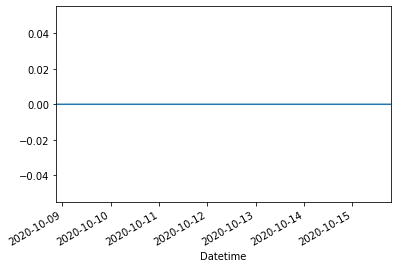

In [52]:
(data - data2).Close.plot()

In [68]:
from alphavantage.price_history import (
  AdjustedPriceHistory, get_results, PriceHistory, IntradayPriceHistory,
  filter_dividends
)


In [70]:
history = IntradayPriceHistory(utc=True, interval=5)


In [71]:
results = history.get('AAPL')


KeyError: 'Meta Data'

In [28]:
import requests
r = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=TTM&outputsize=full&apikey=3W2ZX6J5XD6W1SIZ&interval=1min')
r.json()


{'Meta Data': {'1. Information': 'Intraday (1min) open, high, low, close prices and volume',
  '2. Symbol': 'TTM',
  '3. Last Refreshed': '2020-10-23 16:36:00',
  '4. Interval': '1min',
  '5. Output Size': 'Full size',
  '6. Time Zone': 'US/Eastern'},
 'Time Series (1min)': {'2020-10-23 16:36:00': {'1. open': '9.1900',
   '2. high': '9.1900',
   '3. low': '9.1900',
   '4. close': '9.1900',
   '5. volume': '268'},
  '2020-10-23 16:14:00': {'1. open': '9.2300',
   '2. high': '9.2300',
   '3. low': '9.2300',
   '4. close': '9.2300',
   '5. volume': '1500'},
  '2020-10-23 16:02:00': {'1. open': '9.3200',
   '2. high': '9.3200',
   '3. low': '9.3200',
   '4. close': '9.3200',
   '5. volume': '640'},
  '2020-10-23 16:01:00': {'1. open': '9.3200',
   '2. high': '9.3200',
   '3. low': '9.3200',
   '4. close': '9.3200',
   '5. volume': '12946'},
  '2020-10-23 16:00:00': {'1. open': '9.3200',
   '2. high': '9.3300',
   '3. low': '9.3150',
   '4. close': '9.3200',
   '5. volume': '49767'},
  '202

In [32]:
data = pd.read_json(app_json).T
data['End'] = data.shift(-1).index - data.index 

In [30]:
app_json = json.dumps(r.json()['Time Series (1min)'])


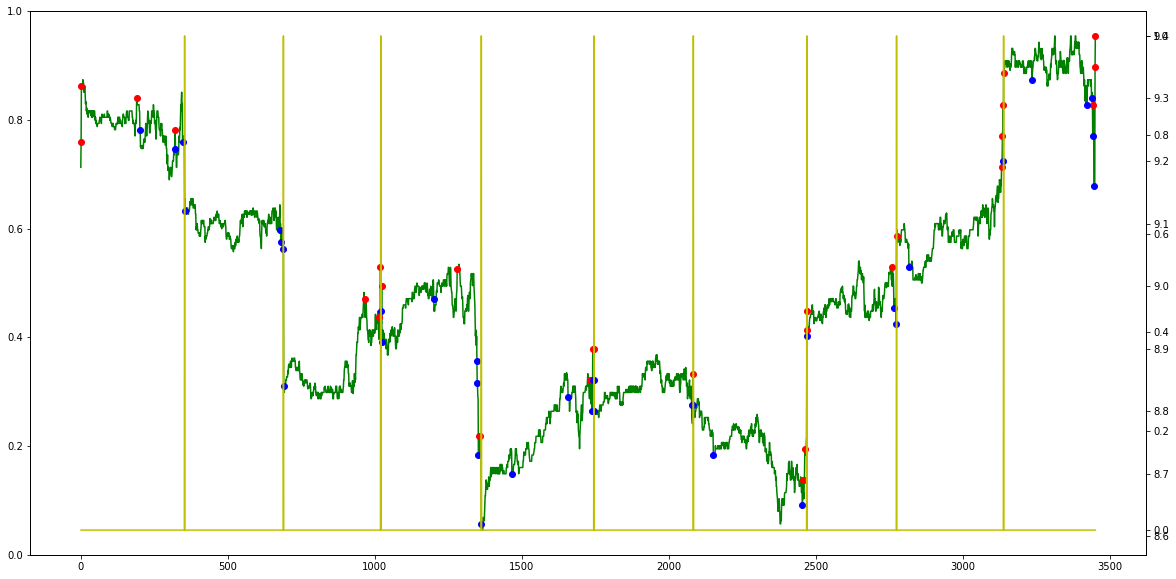

In [190]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))
#ax.twinx().plot(data['5. volume'].to_list(), color ='b')
a =ax.twinx()

index = data.index
val = data['4. close'].to_list()
a.plot(data['4. close'].to_list(), 'g' )

for i in range(0,len(data.loc[data['Upper'] == True ])):
    x = index.get_loc(data.loc[data['Upper'] == True ].index[i])
    y = val[x]
    a.plot(x, y, 'ro')
    
for i in range(0,len(data.loc[data['Lower'] == True ])):
    x = index.get_loc(data.loc[data['Lower'] == True ].index[i])
    y = val[x]
    a.plot(x, y, 'bo')
#a.plot(data[ (data['Upper'] == True )]['4. close'], 'ro' )
#a.plot(data[ (data['Lower'] == True )]['4. close'], 'bo' )

#a.plot(data['1. open'].to_list(), color='pink', marker='.')
#a.plot(data['2. high'].to_list()[:360], 'go')
#a.plot(data['3. low'].to_list()[:360], 'ro')
ax.twinx().plot(data['end'].to_list(), color='y')
#a = ax.twinx()
#a.plot( (data['2. high']-data['3. low']).tolist() , 'go')
#a.plot( ((data['4. close']/data['4. close'].shift(1))).tolist() , 'ro')
#a =ax.twinx()

#a.plot([0,3600], [0.997,0.997])
#a.plot([0,3600], [1.003,1.003])

In [156]:
data['Upper'] = np.nan
data['Lower'] = np.nan
data.loc[data['4. close']/data['4. close'].shift(1) > 1.003,'Upper'] = True
data.loc[data['4. close']/data['4. close'].shift(1) < 0.997,'Lower'] = True
data['Return'] = data['4. close'] / data['4. close'].shift(1)

In [182]:
data.loc[data['Upper'] == True ].index

DatetimeIndex(['2020-10-23 16:14:00', '2020-10-23 16:02:00',
               '2020-10-23 12:16:00', '2020-10-23 09:56:00',
               '2020-10-21 10:25:00', '2020-10-21 09:35:00',
               '2020-10-21 09:02:00', '2020-10-20 16:21:00',
               '2020-10-20 10:48:00', '2020-10-20 09:20:00',
               '2020-10-20 08:34:00', '2020-10-19 09:37:00',
               '2020-10-19 09:32:00', '2020-10-19 09:18:00',
               '2020-10-19 07:55:00', '2020-10-16 09:00:00',
               '2020-10-15 09:30:00', '2020-10-15 09:20:00',
               '2020-10-15 08:58:00', '2020-10-14 16:53:00',
               '2020-10-14 16:29:00', '2020-10-14 09:36:00',
               '2020-10-13 16:01:00', '2020-10-13 09:28:00',
               '2020-10-13 07:48:00', '2020-10-13 07:01:00',
               '2020-10-12 16:14:00', '2020-10-12 07:29:00',
               '2020-10-12 04:40:00', '2020-10-12 04:38:00'],
              dtype='datetime64[ns]', freq=None)

In [185]:
index.get_loc(data.loc[data['Upper'] == True ].index[4])

968

In [17]:
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [64]:
ending = datetime.datetime(2020, 10, 26)
starting = datetime.datetime(2020, 10, 19)
data = yf.download('JUSTDIAL.NS', starting,ending, interval='1m')

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:>

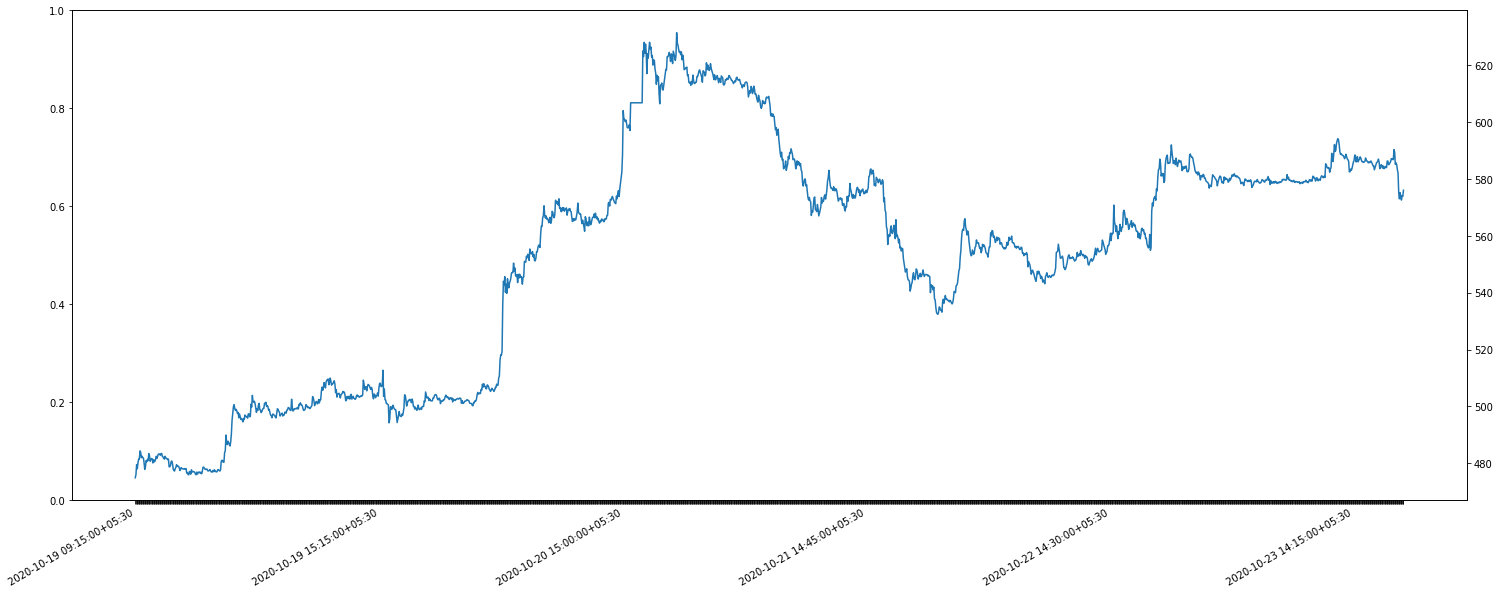

In [70]:
fig, ax = plt.subplots(figsize=(25,10))

def plot_ts(ts, step=5, figsize=(10,7), title=''):
    """
    plot timeseries ignoring date gaps

    Params
    ------
    ts : pd.DataFrame or pd.Series
    step : int, display interval for ticks
    figsize : tuple, figure size
    title: str
    """
    ax1 = ax.twinx()
    ax1.plot(range(ts.dropna().shape[0]), ts.dropna())
    ax1.set_title(title)
    ax1.set_xticks(np.arange(len(ts.dropna())))
    ax1.set_xticklabels(ts.dropna().index.tolist());

    # tick visibility, can be slow for 200,000+ ticks 
    xticklabels = ax.get_xticklabels() # generate list once to speed up function
    for i, label in enumerate(xticklabels):
        if not i%step==0:
            label.set_visible(False)  
    fig.autofmt_xdate()
    return ax

plot_ts(data.Close, step =360, figsize=(25,10))
#plot_ts(data.Volume, step =60, figsize=(25,10))
#ax.plot(data.Close)
#ax.plot([data.index[0], data.index[-1]],[495.22,495.22])
#ax.plot([data.index[0], data.index[-1]],[496.87,496.87])
#ax.twinx().plot(data.Volume, color = 'pink')
#plt.plot(data.Close.to_list())

In [46]:
data[data['Volume'] > 3000]

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-10-19 09:16:00+05:30,474.899994,478.350006,474.299988,476.100006,476.100006,34979
2020-10-19 09:17:00+05:30,476.500000,479.600006,475.549988,479.600006,479.600006,21776
2020-10-19 09:18:00+05:30,479.250000,481.450012,478.100006,478.100006,478.100006,35663
2020-10-19 09:19:00+05:30,478.500000,480.299988,476.049988,480.299988,480.299988,28698
2020-10-19 09:20:00+05:30,481.000000,482.200012,478.299988,481.500000,481.500000,37025
...,...,...,...,...,...,...
2020-10-19 15:25:00+05:30,502.399994,502.450012,500.000000,502.250000,502.250000,17944
2020-10-19 15:26:00+05:30,502.000000,502.000000,500.549988,501.049988,501.049988,8726
2020-10-19 15:27:00+05:30,501.250000,502.649994,500.549988,501.000000,501.000000,11373
